# Compositing from a list of years

In Homework #4, we used the PCs from the Pacific SST field to select specific years from a geopotential height field and averaged them to look at composite mean values for high and low PC values.  In that case, the list of target years was generated from our EOF analysis, and then we used that analysis to extract the years over which to composite. 

However, we might also wish to make a composite of a field (or time series) from a list of years of interest that come a priori from another source -- e.g. years with a wildfire from tree-ring data, years with floods from satellite data, years with volcanic eruptions from ice cores, years with a good or poor harvest from historical records, years with high or low mortality from public health data, etc.  If we have such a list from another sources, we can use it to select years from an DataArray and then average them for the composite mean value.  The only real trick is getting a simple list of years into a datetime format that we can use in Xarray.  This notebook shows one approach you might take.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features


We'll use [20th Century Reanalysis](https://psl.noaa.gov/data/20thC_Rean/) data for the 500mb geopotential height in this example.  We'll make a winter (DJF) seasonal average and we will remove the long-term mean to look at anomalies:

In [2]:
hgt = xr.open_dataset("hgt.500mb.mon.mean.nc",engine="netcdf4",mask_and_scale=True)["hgt"].squeeze(drop="True") # read in the gph dataset and extract the hgt variable only as a DataArray, plus squeeze out the singleton dimension

# create the seasonal average anomalies for DJF 
season_length = 5
end_month = 3

hgt_ = hgt.rolling(time=season_length).mean(skipna=True)
hgt_winter = hgt_[hgt_.time.dt.month == end_month]
hgt_winter = hgt_winter.drop_isel(time=0)
hgt_winter = hgt_winter - hgt_winter.mean(dim="time")

We can first create a simple Python list of our event years, separated by columns.  One could also imagine generating them by reading in a CSV file in Pandas, for instance.  The key is the next line, where we create an xarray DataArray with those years transformed to a datetime using `pd.to_datetime` and calling these by a new dimension name (here `dims="target_years`).  We specify the format of the list so that the conversion to datetime is correct and that `pd.to_datetime` knows these are years (not, for example, nanoseconds).  And now `targetYears` is a DataArray .

In [3]:
# Target year list - the year of the January for some El Nino events
targetYears = [1983, 1987, 1988, 1992, 1995, 1998, 2003, 2010, 2016]

# convert the target years to a DataArray of datatime values, telling Pandas what the format of your list is
targetYears = xr.DataArray(pd.to_datetime(targetYears,format="%Y"), dims="target_years")
print(targetYears) # important sanity check - do these datetimes appear to be correct? 


<xarray.DataArray (target_years: 9)>
array(['1983-01-01T00:00:00.000000000', '1987-01-01T00:00:00.000000000',
       '1988-01-01T00:00:00.000000000', '1992-01-01T00:00:00.000000000',
       '1995-01-01T00:00:00.000000000', '1998-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * target_years  (target_years) datetime64[ns] 1983-01-01 ... 2016-01-01


With a DataArray full of properly formatted datetime years, we can now use this to easily `.sel` those years from our 500mb DataArray.  We use `method="nearest"` to permit difference in days, hours, minutes, etc. between our target year list and the datetime used in the reanalysis data, and we append the  `.mean(dim="target_years")` to take the mean value over the years we extract. 

In [4]:
# the composite is the mean of the 500mb anomalies from the selection of years that most closely match the target years
composite = hgt_winter.sel(time=targetYears, method="nearest").mean(dim="target_years")
composite

<xarray.DataArray 'hgt' (lat: 181, lon: 360)>
array([[ -3.9054363,  -3.9054363,  -3.9054363, ...,  -3.9054363,
         -3.9054363,  -3.9054363],
       [ -3.5049913,  -3.4928927,  -3.492513 , ...,  -3.5149739,
         -3.5106878,  -3.5071073],
       [ -2.9311523,  -2.9158528,  -2.9080946, ...,  -2.9605577,
         -2.947537 ,  -2.934516 ],
       ...,
       [-13.703179 , -13.712999 , -13.711805 , ..., -13.698567 ,
        -13.702582 , -13.707737 ],
       [-13.201551 , -13.2017145, -13.206814 , ..., -13.20459  ,
        -13.205296 , -13.205621 ],
       [-12.448188 , -12.448188 , -12.448188 , ..., -12.448188 ,
        -12.448188 , -12.448188 ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

We can then plot the result of this mean composite calculation:

Text(0.5, 1.0, 'El Nino Events')

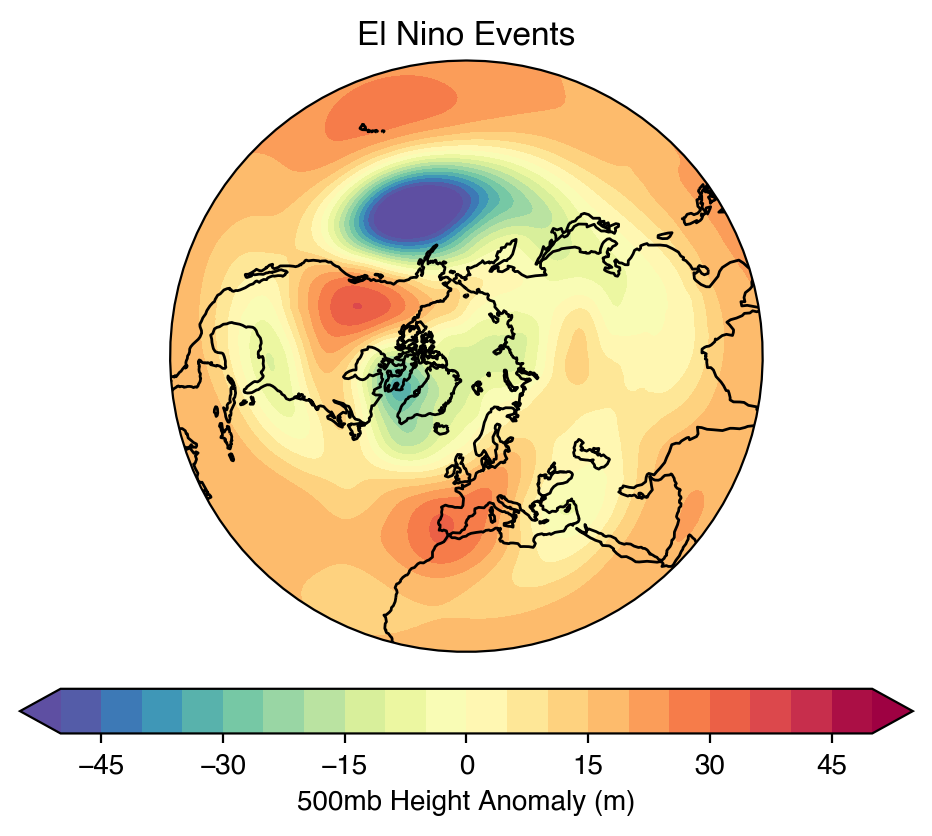

In [5]:
fig, (ax1) = plt.subplots(nrows=1,ncols=1, subplot_kw={'projection': ccrs.NorthPolarStereo()})

# levels to better control the contour plot
levs=np.arange(-50,50.1,5)

# extract coordinates from the DataArray
hgt_lat = hgt.lat
hgt_lon = hgt.lon

# add the cyclic point
from cartopy.util import add_cyclic_point
composite_wrap,hgt_lonc=add_cyclic_point(composite,coord=hgt_lon)

# used to force the projection to remain circulate
import matplotlib.path as mpath

# the plot itself
cs1=ax1.contourf(hgt_lonc,hgt_lat,composite_wrap,levels=levs,transform = ccrs.PlateCarree(),extend='both',cmap="Spectral_r")
ax1.set_extent([0, 360, 10, 90], crs=ccrs.PlateCarree())
cb1 = plt.colorbar(cs1, orientation='horizontal',location='bottom',shrink=0.9,pad=0.05)
cb1.set_label('500mb Height Anomaly (m)')
ax1.coastlines()

# force the plot projection to remain circular despite latitude limits - from https://scitools.org.uk/cartopy/docs/v0.15/examples/always_circular_stereo.html
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)

ax1.set_title('El Nino Events')

Compare this map to the one you generated in Homework #4 - you'll see similarities with the composite from the top 10% of values from your Pacific SST PC1. 